# Ensemble 모델을 이용한_불균형데이터 예측 성능 개선

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
from joblib import dump, load

## Data Obtain

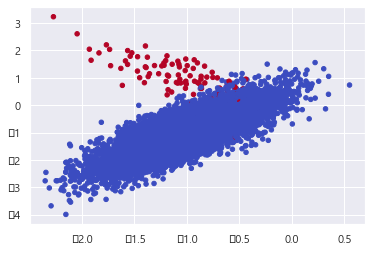

In [3]:
from sklearn.datasets import make_classification
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='coolwarm')

## 1. Bagging for Imbalanced Classification
### Standard Bagging

In [4]:
# define model
from sklearn.ensemble import BaggingClassifier
model = BaggingClassifier()

In [5]:
# define evaluation procedure
from sklearn.model_selection import RepeatedStratifiedKFold
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.865


### Bagging With Random Undersampling
Oversampling the minority class in the bootstrap is referred to as OverBagging; likewise, undersampling the majority class in the bootstrap is referred to as UnderBagging, and combining both approaches is referred to as OverUnderBagging.

In [6]:
# define model
from imblearn.ensemble import BalancedBaggingClassifier
model = BalancedBaggingClassifier()
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.960


## 2. Random Forest for Imbalanced Classification
The main difference between Bagging is that all features (variables or columns) are not used; instead, a small, randomly selected subset of features (columns) is chosen for each bootstrap sample. This has the eect of de-correlating the decision trees (making them more independent), and in turn, improving the ensemble prediction.

### Standard Random Forest

In [7]:
# define model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.867


### Random Forest With Class Weighting

In [8]:
# define model
model = RandomForestClassifier(n_estimators=10, class_weight='balanced')
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.884


### Random Forest With Bootstrap Class Weighting
랜덤포레스트 무작위성(비모수추정)
Note: Your specific results may vary given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

In [9]:
# define model
model = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
roc_list =[]
for i in range(50):
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    # summarize performance
    roc_list.append(np.mean(scores))

array([[<AxesSubplot:title={'center':'AUROC'}>]], dtype=object)

AUROC    0.875907
dtype: float64

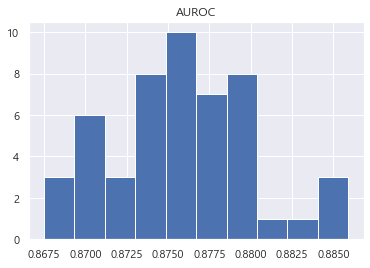

In [10]:
data = pd.DataFrame(roc_list, columns=['AUROC'])
data.hist()
data.mean()

### Random Forest With Random Undersampling

In [11]:
from imblearn.ensemble import BalancedRandomForestClassifier
# define model
model = BalancedRandomForestClassifier(n_estimators=10)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.964


## 3. Easy Ensemble for Imbalanced Classification

... under-sampling is an ecient strategy to deal with class-imbalance. However, the
drawback of under-sampling is that it throws away many potentially useful data.

In [12]:
from imblearn.ensemble import EasyEnsembleClassifier
# define model
model = EasyEnsembleClassifier(n_estimators=10)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.963


## 4. One-Class Classification
One-class classification algorithms can be used for binary classification tasks with a severely skewed class distribution. Although not designed for these types of problems, one-class classication algorithms can be effective for imbalanced classification datasets where there are none or very few examples of the minority class, or datasets where there is no coherent structure to separate the classes that could be learned by a supervised algorithm.

- One-class classification is a feld of machine learning that provides techniques for outlier and anomaly detection.
- How to adapt one-class classifcation algorithms for imbalanced classification with a severely skewed class distribution.
- How to fit and evaluate one-class classification algorithms such as SVM, isolation forest, elliptic envelope, and local outlier factor.

### One-Class SVM, Isolation Forest, Elliptic Envelope, and Local Outlier Factor.

Counter({0: 9990, 1: 10})


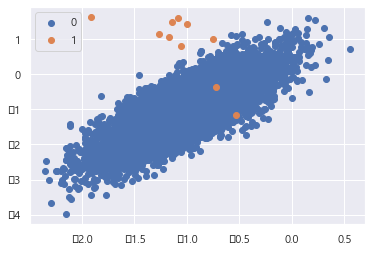

In [13]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.999], flip_y=0, random_state=4)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

### One-Class SVM
The main differerence from a standard SVM is that it is fit in an unsupervised manner and does not provide the normal hyperparameters for tuning the margin like C. Instead, it provides
a hyperparameter nu that controls the sensitivity of the support vectors and should be tuned to the approximate ratio of outliers in the data, e.g. 0.01%.

- Inlier Prediction: +1
- Outlier Prediction: -1

In [14]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2,
stratify=y)
# define outlier detection model
model = OneClassSVM(gamma='scale', nu=0.01)
# fit on majority class
trainX = trainX[trainy==0]
model.fit(trainX)
# detect outliers in the test set
yhat = model.predict(testX)
# mark inliers 1, outliers -1
testy[testy == 1] = -1
testy[testy == 0] = 1
# calculate score
score = f1_score(testy, yhat, pos_label=-1)
print('F-measure: %.3f' % score)

OneClassSVM(nu=0.01)

F-measure: 0.123


### Isolation Forest
Perhaps the most important hyperparameters of the model are the n estimators argument that sets the number of trees to create and the contamination argument, which is used to help define the number of outliers in the dataset. We know the contamination is about 0.01 percent positive cases to negative cases, so we can set the contamination argument to be 0.01.

In [15]:
from sklearn.ensemble import IsolationForest
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# define outlier detection model
model = IsolationForest(contamination=0.01)
# fit on majority class
trainX = trainX[trainy==0]
model.fit(trainX)
# detect outliers in the test set
yhat = model.predict(testX)
# mark inliers 1, outliers -1
testy[testy == 1] = -1
testy[testy == 0] = 1
# calculate score
score = f1_score(testy, yhat, pos_label=-1)
print('F-measure: %.3f' % score)

IsolationForest(contamination=0.01)

F-measure: 0.000


Note: Your specific results may vary given the stochastic nature of the learning algorithm. Consider running the example a few times and compare the average performance.

### Minimum Covariance Determinant

In [16]:
from sklearn.covariance import EllipticEnvelope
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# define outlier detection model
model = EllipticEnvelope(contamination=0.01)
# fit on majority class
trainX = trainX[trainy==0]
model.fit(trainX)
# detect outliers in the test set
yhat = model.predict(testX)
# mark inliers 1, outliers -1
testy[testy == 1] = -1
testy[testy == 0] = 1
# calculate score
score = f1_score(testy, yhat, pos_label=-1)
print('F-measure: %.3f' % score)

EllipticEnvelope(contamination=0.01)

F-measure: 0.157


### Local Outlier Factor
The local outlier factor, or LOF for short, is a technique that attempts to harness the idea of nearest neighbors for outlier detection.

In [17]:
from sklearn.neighbors import LocalOutlierFactor
# make a prediction with a lof model
def lof_predict(model, trainX, testX):
    # create one large dataset
    composite = np.vstack((trainX, testX))
    # make prediction on composite dataset
    yhat = model.fit_predict(composite)
    # return just the predictions on the test set
    return yhat[len(trainX):]
# generate dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.999], flip_y=0, random_state=4)
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2,
stratify=y)
# define outlier detection model
model = LocalOutlierFactor(contamination=0.01)
# get examples for just the majority class
trainX = trainX[trainy==0]
# detect outliers in the test set
yhat = lof_predict(model, trainX, testX)
# mark inliers 1, outliers -1
testy[testy == 1] = -1
testy[testy == 0] = 1
# calculate score
score = f1_score(testy, yhat, pos_label=-1)
print('F-measure: %.3f' % score)

F-measure: 0.138


# END